## Imports

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

### Custom

In [2]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.imagenet_classes import get_labels_by_indices
from cv_geoguessr.utils.select_k_best import select_k_best
from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model constants

In [3]:
NUMBER_OF_GRID_ELEMENTS = 100
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'

LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR


## Download ResNet50

In [14]:
resnet50 = models.resnet50(True, True)

In [15]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [16]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.Resize((224, 224)),
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, 0.04)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


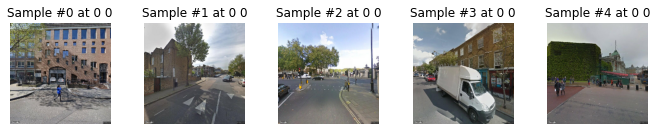

In [19]:
examples = enumerate(test_loader)
batch_idx, (example_images, example_coordinates) = next(examples)

eval_images = example_images[:5]
eval_coordinates = example_coordinates[:5]

plot_images(eval_images, eval_coordinates, IMAGENET_MEAN, IMAGENET_STD)

In [20]:
resnet50.eval()

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(eval_images), dim=1)

for index, entry in enumerate(output):
    print(index, get_labels_by_indices(select_k_best(entry, 5)))

0 ['prison, prison house', 'palace', 'traffic light, traffic signal, stoplight', 'castle', 'manhole cover']
1 ['traffic light, traffic signal, stoplight', 'castle', 'monastery', 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', 'streetcar, tram, tramcar, trolley, trolley car']
2 ['traffic light, traffic signal, stoplight', 'limousine, limo', 'dock, dockage, docking facility', 'cab, hack, taxi, taxicab', 'pole']
3 ['recreational vehicle, RV, R.V.', 'moving van', 'minibus', 'limousine, limo', 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi']
4 ['palace', 'triumphal arch', 'castle', 'bell cote, bell cot', 'monastery']


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)